## Distribution Federate

### Steps to configure a Distribution Federate
1. Broker already initialized in Transmission federate, so it is not needed.
2. Creating a federate with information.
3. Enlist publication and subscription items
4. Load system data (DSS file) for distribution system simulation
5. Fix simulation step and time for co-simulaiton 
6. Run co-simulation

 
### Simulator
OpenDSS has been used as a simulator for distribution systems through the Python wrapper OpenDSSDirect.py, which enables direct interaction with the OpenDSS engine without requiring the COM interface. This makes it faster and more compatible across different platforms [1]. It provides a functional API for executing OpenDSS commands and retrieving data, making it well-suited for integration with data science tools like Pandas and NumPy.

### Methodology
The total load of the IEEE 34-bus distribution system varies with a standard deviation of 2.5%. The varied load is published so that it gets reflected in the transmission system. When the transmission federate runs the simulation, it will use the updated load from the distribution system. Since the total load of the 34-bus distribution system does not match the load at Bus 4 of the IEEE-14 transmission system, it must be scaled.
#### To run the co-simulation, we must run Transmission_Federate.ipynb & Distrubtion_Federate.ipynb together (run all cells at once).

Import helics and openDSSDirect.
- If helics has not been installed, run !pip install helics inside a cell.
- If OpenDSSDirect.py has not been installed, run !pip OpenDSSDirect.py inside a cell.

In [1]:
import os
import sys
import numpy as np
import helics as h
import opendssdirect as dss
from opendssdirect.utils import run_command
import csv
import pandas as pd
import matplotlib.pyplot as plt

Here, we directly create a distribution federate, as the broker has already been created in the transmission federate.

##  Create a Distribution Federate info object

In [2]:
federate_name='34Bus'
fedinfo = h.helicsCreateFederateInfo() 
h.helicsFederateInfoSetCoreName(fedinfo, f"{federate_name}") 
h.helicsFederateInfoSetCoreTypeFromString(fedinfo, "zmq") 
h.helicsFederateInfoSetCoreInitString(fedinfo, "--federates=1")
h.helicsFederateInfoSetTimeProperty(fedinfo, h.helics_property_time_delta, 0.01)


## Create Value Federate

In [3]:
fed = h.helicsCreateValueFederate(f"{federate_name}", fedinfo)
print(f"{federate_name}: Value federate created", flush=True)

34Bus: Value federate created


In [4]:
PUBLICATIONS = {}
SUBSCRIPTIONS = {}
publications= {
      "sourcebus/TotalPower": {
      "element_name": "sourcebus",
      "element_type": "Bus",
      "topic": "Totalpower",
      "type": "complex",
      "value": "Power",
      "unit": "kva",
      "fold": "sum"
    }
  }
subscriptions= {
    "sourcebus/pu": {
      "element_name": "sourcebus",
      "element_type": "Bus",
      "topic": "TransmissionSim/Voltage_4",
      "required": True,
      "key": "TransmissionSim/transmission_voltage",
      "type": "complex",
      "unit": "pu",
      "value": "Voltage"
    }
  }

for k, v in publications.items():
    pub = h.helicsFederateRegisterTypePublication(fed, v["topic"], "complex", "")
    PUBLICATIONS[k] = pub
for k, v in subscriptions.items():
    sub = h.helicsFederateRegisterSubscription(fed, v["topic"], "")
    SUBSCRIPTIONS[k] = sub

## Entering execution

In [5]:
h.helicsFederateEnterExecutingMode(fed)

## Load DSS file and initial simulation

Load the IEEE 34-bus distribution system files for simulation. OpenDSS is used for the distribution system simulation. A 2.5% standard deviation in load variation has been introduced for the simulation period, which will be reflected on the transmission side. Scaling is applied to adjust the total load of the 34-bus system to make it equivalent to the load at the bus in the transmission system.

In [6]:
feeder_name = '34Bus'
path34 = os.getcwd()
consistent_random_object = np.random.RandomState(981)
load_profile_random = consistent_random_object.normal(1,0.025, 15) #0.02
print('------ Running the {} feeder in opendss'.format(feeder_name))

print(path34)
run_command(f'compile "{os.path.join(path34, "DSSfiles", "Master.dss")}"')

if dss.Text.Result() == '':
    print('------ Success for the test run -----')
else:
    print('------ Opendss failed ----')
    print(f'Error is "{dss.Text.Result()}"!')
run_command("BatchEdit Load..* Vminpu=0.9")
run_command("New Loadshape.dummy npts=60 sinterval=1 Pmult=[file=dummy_profile.txt]")
run_command("BatchEdit Load..* Yearly=dummy")
run_command("set mode=yearly number=60 stepsize=1s")
dss.Solution.ControlMode(2)
print(f"dss.Solution.Mode()={dss.Solution.Mode()}")
print(f"dss.Solution.ControlMode()={dss.Solution.ControlMode()}")

BASEKV = dss.Vsources.BasekV()
loadname_all=[]
loadkw_all=[]
loadkvar_all=[]
num_loads = dss.Loads.Count()
dss.Loads.First()
for i in range(num_loads):
    loadname = dss.Loads.Name()
    loadkw = dss.Loads.kW()
    loadkvar = dss.Loads.kvar()
    loadname_all.append(loadname)
    loadkw_all.append(loadkw)
    loadkvar_all.append(loadkvar)
    dss.Loads.Next()
print(f"Total power base line is {dss.Circuit.TotalPower()}")
base_load = abs(dss.Circuit.TotalPower()[0])
loadkw_dict = dict(zip(loadname_all, loadkw_all))
loadkvar_dict = dict(zip(loadname_all, loadkvar_all))
allnodenames = dss.Circuit.AllNodeNames()
num_nodes = len(allnodenames)
os.chdir(path34)

------ Running the 34Bus feeder in opendss
C:\Users\pb1052\Desktop\powercybertraining.github.io\pct\modules\06
------ Success for the test run -----
dss.Solution.Mode()=2
dss.Solution.ControlMode()=2
Total power base line is [-970.670418582271, -150.4365356059942]


## Main Loop for Co-simulation

This is the main loop for co-simulation. It runs the distribution system simulation at each given time step. The publication of active and reactive power and the subscription to voltage magnitude and angle occur simultaneously until the loop terminates.

In [7]:
dss.Vsources.PU(1.01)
scale = 0.478*100/0.970657
total_time=15
simulation_step_time=1
current_time=0
V_mag=[]
V_ang=[]
load_var=[]
time_list=[]
for request_time in np.arange(0, total_time, simulation_step_time):
    while current_time < request_time:
        current_time = h.helicsFederateRequestTime(fed, request_time)
    print(f"current_time={current_time}")
    dss.run_command("Solve number=1 stepsize=1s")
    allbusmagpu = dss.Circuit.AllBusMagPu()
    S = dss.Circuit.TotalPower() 
    print(f"Total power={dss.Circuit.TotalPower()}")
    print(f"Overall after adjustment S={S}")
    P = -S[0]
    Q = -S[1]

    P = P*scale
    Q = Q*scale
    h.helicsPublicationPublishComplex(pub, P, Q)
    print("Sent Active power at time {}: {} kw".format(current_time, P))
    print("Sent Reactive power at time {}: {} kvar".format(current_time, Q))
    print("=============================")
    for key, sub in SUBSCRIPTIONS.items():
        val = h.helicsInputGetComplex(sub)
        if subscriptions[key]['value'] == 'Voltage':

            print("Received voltage mag at time {}: {} pu".format(current_time, val.real))
            print("Received voltage ang at time {}: {} rad".format(current_time, val.imag))

            voltage, angle_rad = val.real,val.imag
            angle_deg = np.degrees(angle_rad)
            if current_time == 0:
                print('manually set up first step voltage')
                angle_deg = 0
                voltage = 1
            dss.Vsources.AngleDeg(angle_deg)
            dss.Vsources.PU(voltage)
    V_mag.append(voltage)
    V_ang.append(angle_rad)
    time_list.append(current_time)
    load_var.append(dss.Circuit.TotalPower())
    dss.Loads.First()
    for j in range(num_loads):
        loadname = dss.Loads.Name()
        load_mult = load_profile_random[int(current_time)]
        loadkw_new = load_mult * loadkw_dict[loadname]
        loadkvar_new = load_mult * loadkvar_dict[loadname]
        run_command('edit load.{ln} kw={kw}'.format(ln=loadname, kw=loadkw_new))
        run_command('edit load.{ln} kvar={kw}'.format(ln=loadname, kw=loadkvar_new))
        dss.Loads.Next()

h.helicsFederateDestroy(fed)
print('Federate finalized')

current_time=0
Total power=[-970.6902667113632, -150.45499435944785]
Overall after adjustment S=[-970.6902667113632, -150.45499435944785]
Sent Active power at time 0: 47801.63821906519 kw
Sent Reactive power at time 0: 7409.155582643104 kvar
Received voltage mag at time 0: -1e+49 pu
Received voltage ang at time 0: 0.0 rad
manually set up first step voltage
current_time=1.0
Total power=[-904.7684976969771, -83.90254096233245]
Overall after adjustment S=[-904.7684976969771, -83.90254096233245]
Sent Active power at time 1.0: 44555.32097323309 kw
Sent Reactive power at time 1.0: 4131.780286959751 kvar
Received voltage mag at time 1.0: 1.0114034500520985 pu
Received voltage ang at time 1.0: -0.07696511657375282 rad
current_time=2.0
Total power=[-993.7380619696381, -178.1235387779522]
Overall after adjustment S=[-993.7380619696381, -178.1235387779522]
Sent Active power at time 2.0: 48936.626802411876 kw
Sent Reactive power at time 2.0: 8771.692939510162 kvar
Received voltage mag at time 2.0:

Here we plot the voltage magnitude and angle received from Transmission Federate.

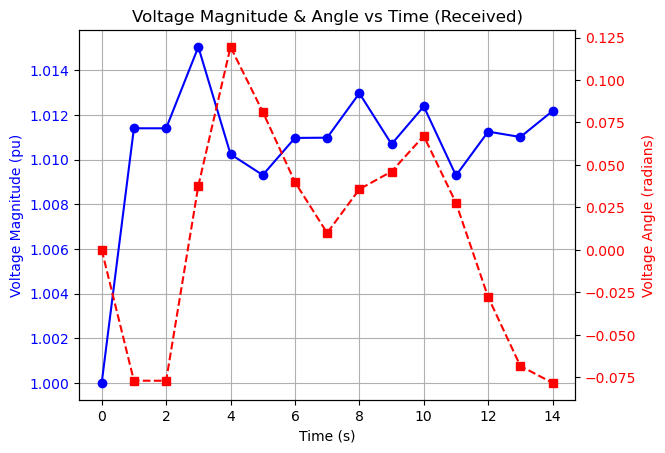

In [8]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(6.4, 4.8))
ax1.plot(time_list, V_mag, label="Voltage Magnitude (pu)", marker='o', linestyle='-', color='b')
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Voltage Magnitude (pu)", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(time_list, V_ang, label="Voltage Angle (radians)", marker='s', linestyle='--', color='r')
ax2.set_ylabel("Voltage Angle (radians)", color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title("Voltage Magnitude & Angle vs Time (Received)")
ax1.grid(True)
plt.show()


##  Result Analysis
The distribution federate starts to receive the voltage angle and magnitude at 1 second. After sending the varying P & Q signals to the transmission federate, it receives the updated voltage value from the transmission federate based on the simulation results. The load variation on the distribution side is reflected on the transmission side, which causes a change in the voltage at bus 4 of the transmission system, to which the distribution feeder is connected.


Here, we plot the total active load variation of the IEEE-34 bus distribution system over the simulation period.

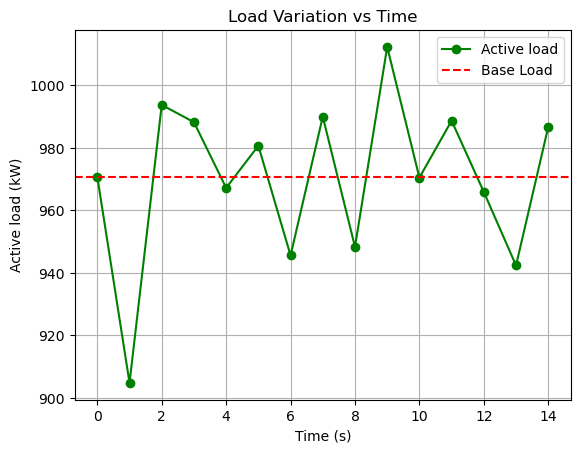

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
P_var = [abs(sublist[0]) for sublist in load_var]
plt.figure(figsize=(6.4, 4.8))
plt.plot(time_list, P_var, label="Active load", marker='o', linestyle='-', color='g')
plt.axhline(base_load, color='r', linestyle='--', label=f"Base Load")  # Horizontal line for base load

plt.xlabel("Time (s)")
plt.ylabel("Active load (kW)")
plt.title("Load Variation vs Time")
plt.legend()
plt.grid(True)
plt.show()


## References

[1]“OpenDSSDirect.py — OpenDSSDirect.py 0.9.1 documentation,” Dss-extensions.org, 2017. https://dss-extensions.org/OpenDSSDirect.py/ (accessed Feb. 16, 2025).